In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, rot
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

Average GABA synapse count: 143.56


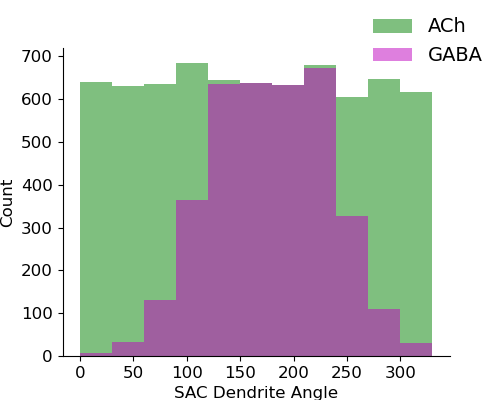

In [4]:
rng = np.random.default_rng()
dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
conf = configs.sac_mode_config()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_theta_mode"] = "experimental"

dist_conf = copy.deepcopy(conf)
dist_conf["seed"] = 4
dist_conf["sac_theta_mode"] = "experimental"
angle_dist_fig, angle_dist_ax = ana.sac_angle_distribution(
    dist_conf, rho=1, n_nets=25, bins=[12], incl_yticks=True, figsize=(5, 4))

In [5]:
# TODO: get this working when synapses without I are included, such that
# this can be combined easily with a probability matrix including all of the synapses
# as well (so the E without I can count as "unopposed" when their probability is high enough,
# or be used as part of a linear metric that adds up the probabilities, modulated by the timing)
def calc_sweep_times(
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    times = {}  # dir -> syn -> trans
    times = np.zeros((len(dir_rads), locs.shape[0], 2)) # shape (8 [dir], N, 2 [EI])
    for i, r in enumerate(dir_rads):
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(locs.shape[0]):
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i, syn, j] = dist / vel
                
    return times

In [6]:
n_syns = 1000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

thetas, deltas, abs_deltas, dir_probs, times, has_gaba = [{} for _ in range(6)]
corrs, mean_abs_deltas = [], []

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    # n = np.sum(sac_net.gaba_here)
    has_gaba[rho] = sac_net.gaba_here
    n = len(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"]
    ts[:, 1] = sac_net.thetas["I"]
    thetas[rho] = ts
    paired_ts = ts[sac_net.gaba_here, :]
    corrs.append(circcorrcoef(np.radians(paired_ts[:, 0]), np.radians(paired_ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(paired_ts[:, 0] - paired_ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"]
    locs[:, 1, :] = sac_net.bp_locs["I"]
    times[rho] = calc_sweep_times(locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"]

corrs = np.array(corrs)

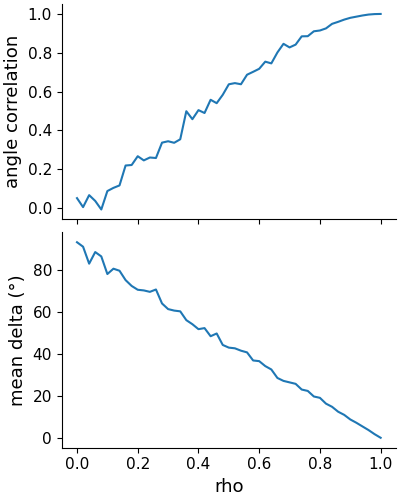

In [7]:
real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs)
real_corr_ax[0].set_ylabel("angle correlation", fontsize=13)
real_corr_ax[1].plot(rhos, mean_abs_deltas)
real_corr_ax[1].set_ylabel("mean delta (°)", fontsize=13)
real_corr_ax[-1].set_xlabel("rho", fontsize=13)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax)

In [8]:
e_early_thresh = 5.

time_diff = {r: ts[:, has_gaba[r], 1] - ts[:, has_gaba[r], 0] for r, ts in times.items()}
abs_time_diff = {r: np.abs(diffs) for r, diffs in time_diff.items()}
abs_time_diff_sum = {r: np.sum(diffs, axis=1) for r, diffs in abs_time_diff.items()}
e_early_diff_sum = {
    r: np.array([np.sum(d[d > 0.]) for d in diff]) 
    for r, diff in time_diff.items()
}
e_early = {r: (diffs > e_early_thresh) for r, diffs in time_diff.items()}
e_early_sum = {r: np.sum(early, axis=1) for r, early in e_early.items()}
total_prob = {r: np.sum(pr, axis=0) for r, pr in dir_probs.items()}

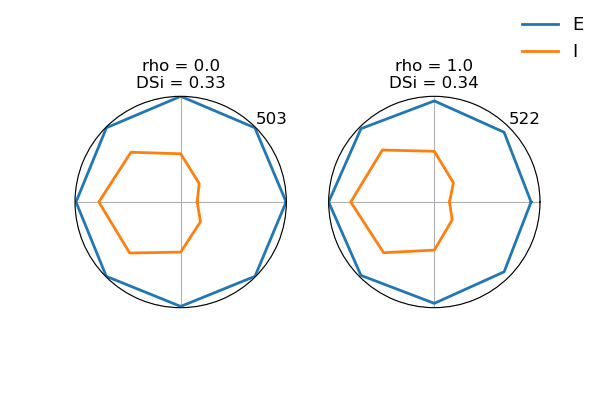

In [9]:
polar_rhos = [0.0, 1.0]
dir_sort = np.array(dir_labels).argsort()
circ_total_prob = {r: pr[dir_sort, :] for r, pr in total_prob.items()}
circ_total_prob = {
    r: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for r, pr in circ_total_prob.items()
}

prob_polar_fig = plt.figure(figsize=(6, 4))
prob_polar_ax = []
for i, r in enumerate(polar_rhos):
    ax = prob_polar_fig.add_subplot(1, len(polar_rhos), i + 1, projection="polar")
    prob_polar_ax.append(ax)
    ax.plot(circle, circ_total_prob[r][:, 0], linewidth=2, label="E" if not i else None)
    ax.plot(circle, circ_total_prob[r][:, 1], linewidth=2, label="I" if not i else None)
    radius = np.max(circ_total_prob[r])
    dsi, _ = calc_tuning(total_prob[r][:, 1], dir_labels)
    ax.set_title("rho = " + str(r) + "\nDSi = %.2f" % dsi)
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=12)

prob_polar_fig.legend(fontsize=13, frameon=False)


In [10]:
dir_labels

array([225, 270, 315,   0,  45,  90, 135, 180])